# Analysis of Top-K Applicant Rankings Using JobBERT V2

This notebook explores how JobBERT V2 ranks applicants for a collection of job postings and examines representation patterns among the highest-scoring candidates. We load the CV-job similarity scores produced earlier, link them to the job records, and compute a rank for every applicant within each job.

Once the ranking is established, we extract the top candidates at different cutoffs (top-3, top-5, top-7, top-10). These ranked subsets will later help us study whether certain demographic groups appear more frequently at the top of the list. The goal is to identify trends—such as gender or ethnicity dominance—in the most competitive positions for each role.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
OUT_DIR = "similarity_matching_output"

CV_JOB_PATH = os.path.join(OUT_DIR, "cv_job_similarity_eu_ratio_jb_v2.csv")
JOB_RECORDS_PATH = "job_records.csv"

In [3]:
cv_job_df = pd.read_csv(CV_JOB_PATH)
job_df = pd.read_csv(JOB_RECORDS_PATH)

## 1. Aggregate top k applicants per job

### a. Helper functions

**Function to Retrieve Top-K Applicants for a Single Job**

This function selects the highest-ranked applicants for a given job based on their similarity scores.
It assumes that the main dataframe already contains a precomputed rank column for each (`job_id`, `cv_id`) pair.

In [4]:
def get_top_k_applicants_for_job(cv_job_ranked: pd.DataFrame,
                                 job_id: str,
                                 k: int = 10) -> pd.DataFrame:
    """
    Return the top-k applicants for a given job_id based on similarity score.
    Assumes cv_job_ranked already has a 'rank' column per job.
    """
    subset = cv_job_ranked[
        (cv_job_ranked["job_id"] == job_id) &
        (cv_job_ranked["rank"] <= k)
    ].copy()
    
    # Optional: enforce sorting by rank
    subset = subset.sort_values("rank")
    return subset

**Function to Retrieve Top-K Applicants for All Jobs**

This function loops over all job postings in the job records and extracts the top-k candidates for each job.
The result is a unified dataframe that contains one row per selected applicant per job.

In [5]:
def get_top_k_for_all_jobs(cv_job_ranked: pd.DataFrame,
                           job_df: pd.DataFrame,
                           k: int = 10) -> pd.DataFrame:
    """
    For every job in job_df, collect the top-k applicants (by similarity).
    Returns a dataframe with one row per (job_id, cv_id) up to rank k.
    """
    # Use only job_ids that exist in the job_records
    job_ids = job_df["job_id"].unique()
    
    top_k_list = []
    for jid in job_ids:
        top_k = get_top_k_applicants_for_job(cv_job_ranked, jid, k=k)
        top_k_list.append(top_k)
    
    if not top_k_list:
        return pd.DataFrame()
    
    all_top_k = pd.concat(top_k_list, ignore_index=True)
    return all_top_k

### b. Ranking All Applicants Per Job

In [6]:
# 1) Compute a rank for every (job, cv) pair, sorted by similarity
cv_job_ranked = (
    cv_job_df
    .sort_values(["job_id", "similarity"], ascending=[True, False])
    .copy()
)

cv_job_ranked["rank"] = (
    cv_job_ranked
    .groupby("job_id")
    .cumcount() + 1  # rank starts at 1
)

### c. Aggregate Top-K and merge job metadata

In [7]:
top10_all_jobs = get_top_k_for_all_jobs(cv_job_ranked, job_df, k=10)

In [8]:
top10_all_jobs = (
    get_top_k_for_all_jobs(cv_job_ranked, job_df, k=10)
    .merge(
        job_df[["job_id", "role", "domain", "level"]],
        on="job_id",
        how="left",
        suffixes=("", "_from_job_records")
    )
)

top10_all_jobs.to_csv(os.path.join(OUT_DIR, "top10_all_jobs_eu_ratio_jb_v2.csv"), index=False)

top10_all_jobs.head()

,cv_id,name,gender,ethnicity,role,job_id,job_role,job_domain,job_level,job_text,similarity,rank,role_from_job_records,domain,level
0,CV_378,Kwame Mensah,male,african,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.632322,1,Software Engineer,tech,Junior
1,CV_540,John Smith,male,western_european,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.613077,2,Software Engineer,tech,Junior
2,CV_414,Kofi Mensah,male,african,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.606969,3,Software Engineer,tech,Junior
3,CV_180,Rajesh Patel,male,south_asian,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.605587,4,Software Engineer,tech,Junior
4,CV_288,Ananya Das,female,south_asian,Software Engineer,JOB_0,Software Engineer,tech,Junior,Hiring a Junior Software Engineer to implement...,0.605134,5,Software Engineer,tech,Junior


---
---

## 2. Representation Analysis Across Multiple Ranking Cutoffs

In this section, we build on the aggregated top-10 candidate list created earlier and examine how demographic representation changes at different ranking depths. Using modular helper functions, we compute gender and ethnicity proportions for several cutoffs (_top-3, top-5, top-7, and top-10_) based on the same underlying dataset.

By comparing these windows, we can observe whether certain demographic groups appear more frequently at the very top, whether representation becomes more balanced as the cutoff expands, or whether specific patterns persist regardless of ranking depth.

In [9]:
path = os.path.join(OUT_DIR, 'top10_all_jobs_eu_ratio_jb_v2.csv')
top10_all_jobs = pd.read_csv(path)  

### helper functions

In [10]:
JOBS_COUNT = len(top10_all_jobs['job_id'].unique())

In [11]:
def get_top_k_counts(top10_df, k=3):
    df_k = top10_df[top10_df["rank"] <= k].copy()
    
    gender_counts = df_k.groupby('job_id')['gender'].value_counts().unstack(fill_value=0)
    eth_counts = df_k.groupby('job_id')['ethnicity'].value_counts().unstack(fill_value=0)
    
    counts_per_job = (
        gender_counts.merge(
            eth_counts,
            on='job_id',
            how="left",
        )
    )
    
    return counts_per_job

In [12]:
def get_categorical_ratios(topk_counts, k=3):
    gender_cols = ["female", "male"]
    ethnicity_cols = [c for c in top3_counts.columns if c not in gender_cols + ["job_id"]]
    total_slots = JOBS_COUNT * k

    topk_gender_ratios = pd.Series(
        {
            "female": topk_counts['female'].sum(skipna=True) / total_slots,
            "male": topk_counts['male'].sum(skipna=True) / total_slots,
        }
    )

    ethnicity_ratios = (topk_counts[ethnicity_cols].sum() / total_slots).sort_values(ascending=False)

    return topk_gender_ratios, ethnicity_ratios

### a. TOP 3

In [13]:
top3_counts = get_top_k_counts(top10_all_jobs, k=3)

In [14]:
top3_gender_ratios, top3_ethnicity_ratios = get_categorical_ratios(topk_counts=top3_counts, k=3)

print("Average gender proportions across jobs (top-3):")
print("==============================================")
print(top3_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-3):")
print("==============================================")
for eth, ratio in top3_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-3):
female    0.414352
male      0.585648
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-3):
western_european         : 0.498 (49.8%)
african                  : 0.229 (22.9%)
east_southeast_asian     : 0.116 (11.6%)
arabic_middle_eastern    : 0.065 (6.5%)
hispanic_latin_american  : 0.046 (4.6%)
south_asian              : 0.046 (4.6%)


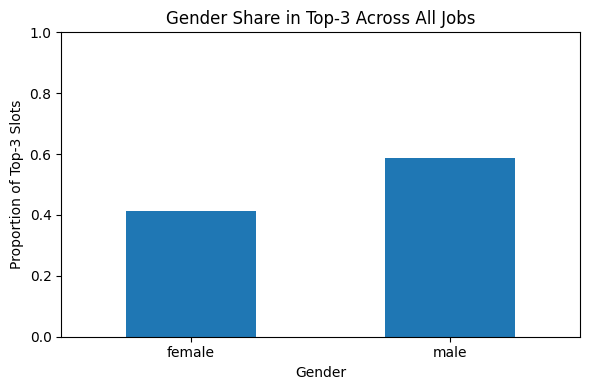

In [15]:
plt.figure(figsize=(6, 4))
top3_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-3 Across All Jobs")
plt.ylabel("Proportion of Top-3 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

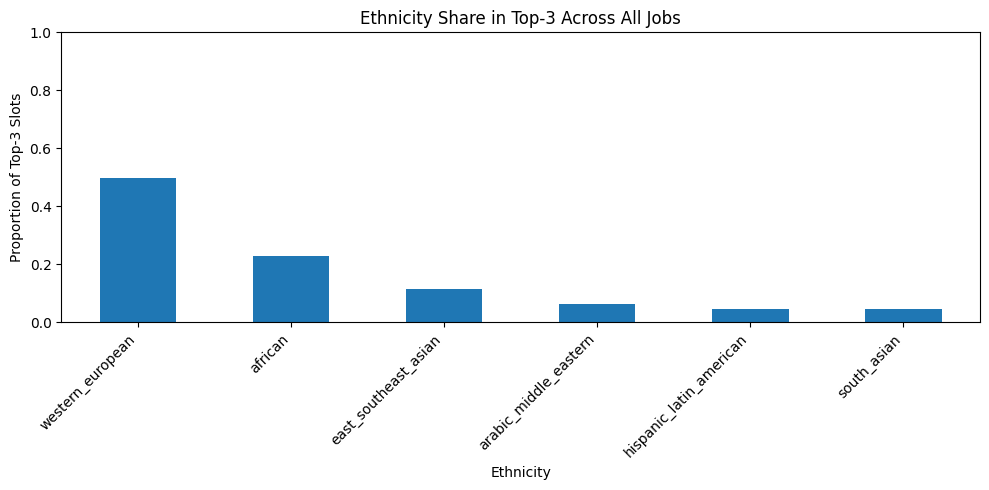

In [16]:
plt.figure(figsize=(10, 5))
top3_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-3 Across All Jobs")
plt.ylabel("Proportion of Top-3 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

### a. TOP 4

In [17]:
top4_counts = get_top_k_counts(top10_all_jobs, k=4)

In [18]:
top4_gender_ratios, top4_ethnicity_ratios = get_categorical_ratios(topk_counts=top4_counts, k=4)

print("Average gender proportions across jobs (top-4):")
print("==============================================")
print(top4_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-4):")
print("==============================================")
for eth, ratio in top4_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-4):
female    0.432292
male      0.567708
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-4):
western_european         : 0.486 (48.6%)
african                  : 0.220 (22.0%)
east_southeast_asian     : 0.118 (11.8%)
arabic_middle_eastern    : 0.075 (7.5%)
hispanic_latin_american  : 0.052 (5.2%)
south_asian              : 0.049 (4.9%)


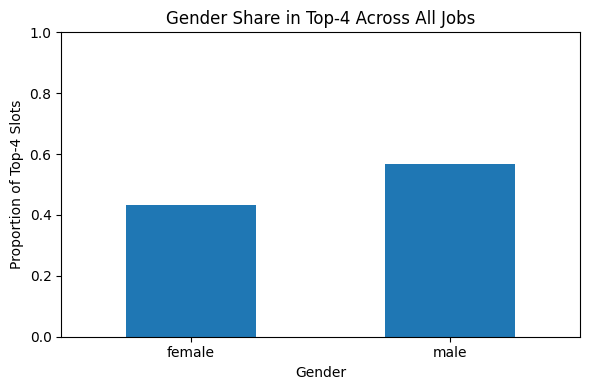

In [19]:
plt.figure(figsize=(6, 4))
top4_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-4 Across All Jobs")
plt.ylabel("Proportion of Top-4 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

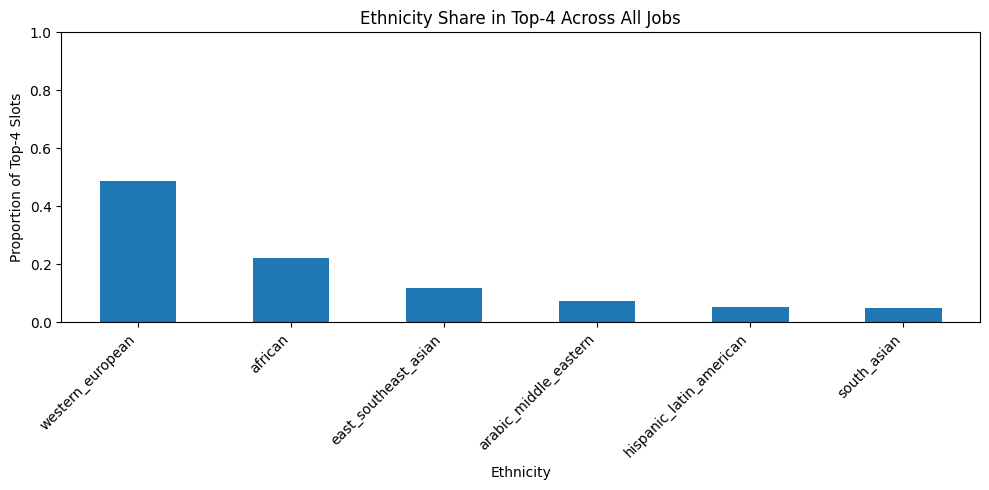

In [20]:
plt.figure(figsize=(10, 5))
top4_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-4 Across All Jobs")
plt.ylabel("Proportion of Top-4 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

### b. TOP 5

In [21]:
top5_counts = get_top_k_counts(top10_all_jobs, k=5)

In [22]:
top5_gender_ratios, top5_ethnicity_ratios = get_categorical_ratios(topk_counts=top5_counts, k=5)

print("Average gender proportions across jobs (top-5):")
print("==============================================")
print(top5_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-5):")
print("==============================================")
for eth, ratio in top5_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-5):
female    0.444444
male      0.555556
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-5):
western_european         : 0.454 (45.4%)
african                  : 0.217 (21.7%)
east_southeast_asian     : 0.126 (12.6%)
arabic_middle_eastern    : 0.082 (8.2%)
hispanic_latin_american  : 0.067 (6.7%)
south_asian              : 0.054 (5.4%)


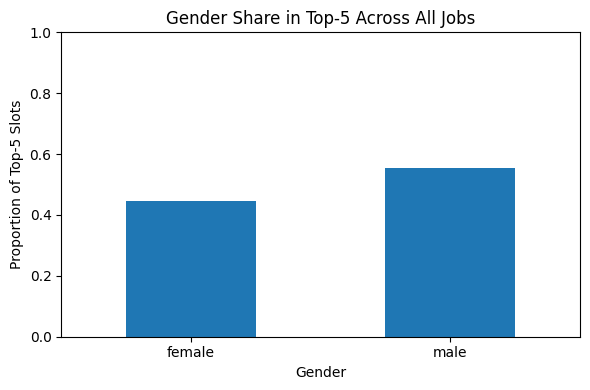

In [23]:
plt.figure(figsize=(6, 4))
top5_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-5 Across All Jobs")
plt.ylabel("Proportion of Top-5 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

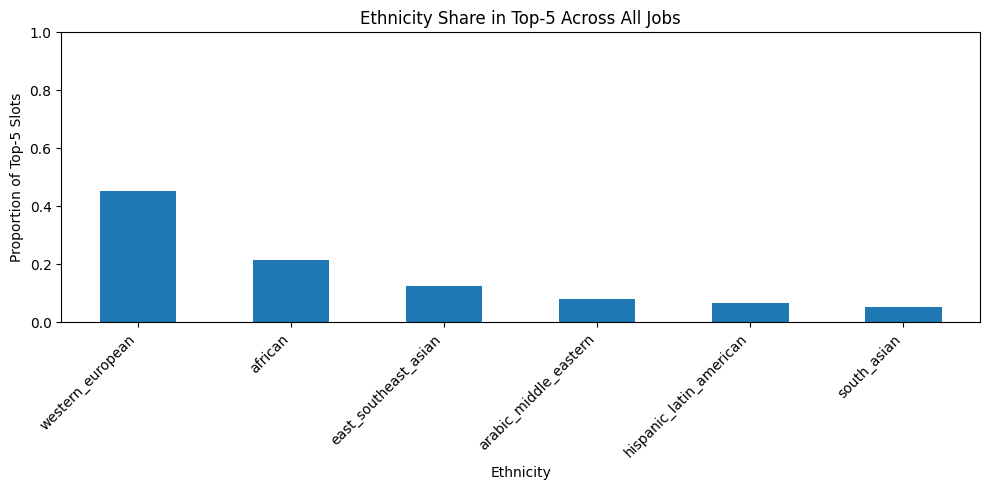

In [24]:
plt.figure(figsize=(10, 5))
top5_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-5 Across All Jobs")
plt.ylabel("Proportion of Top-5 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

### c. TOP 7

In [25]:
top7_counts = get_top_k_counts(top10_all_jobs, k=7)

In [26]:
top7_gender_ratios, top7_ethnicity_ratios = get_categorical_ratios(topk_counts=top7_counts, k=7)

print("Average gender proportions across jobs (top-7):")
print("==============================================")
print(top7_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-7):")
print("==============================================")
for eth, ratio in top7_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-7):
female    0.467262
male      0.532738
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-7):
western_european         : 0.408 (40.8%)
african                  : 0.212 (21.2%)
east_southeast_asian     : 0.138 (13.8%)
arabic_middle_eastern    : 0.106 (10.6%)
hispanic_latin_american  : 0.072 (7.2%)
south_asian              : 0.063 (6.3%)


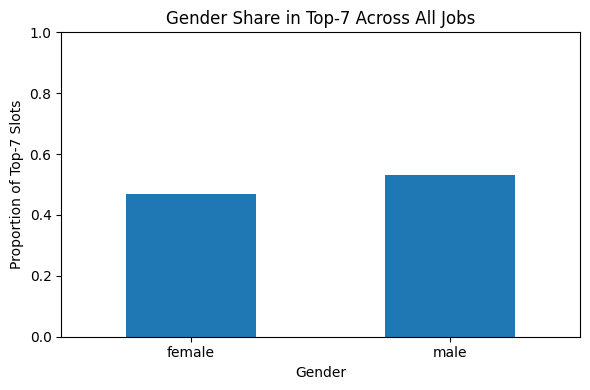

In [27]:
plt.figure(figsize=(6, 4))
top7_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-7 Across All Jobs")
plt.ylabel("Proportion of Top-7 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

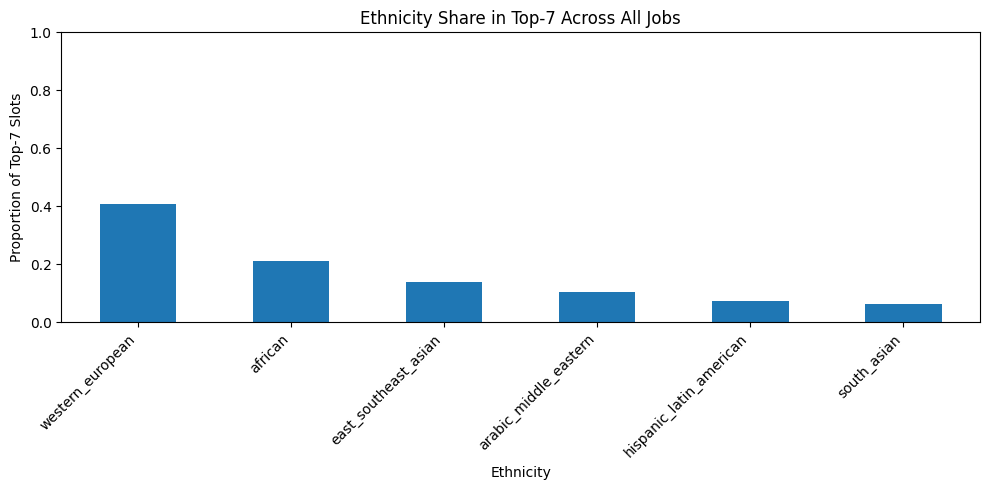

In [28]:
plt.figure(figsize=(10, 5))
top7_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-7 Across All Jobs")
plt.ylabel("Proportion of Top-7 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

### c. TOP 10

In [29]:
top10_counts = get_top_k_counts(top10_all_jobs, k=10)

In [30]:
top10_gender_ratios, top10_ethnicity_ratios = get_categorical_ratios(topk_counts=top10_counts, k=10)

print("Average gender proportions across jobs (top-10):")
print("==============================================")
print(top10_gender_ratios)

print("\n**********************************************\n")

print("Average ethnicity proportions across jobs (top-10):")
print("==============================================")
for eth, ratio in top10_ethnicity_ratios.items():
    print(f"{eth:<25}: {ratio:.3f} ({ratio*100:.1f}%)")

Average gender proportions across jobs (top-10):
female    0.475694
male      0.524306
dtype: float64

**********************************************

Average ethnicity proportions across jobs (top-10):
western_european         : 0.362 (36.2%)
african                  : 0.217 (21.7%)
east_southeast_asian     : 0.151 (15.1%)
arabic_middle_eastern    : 0.115 (11.5%)
hispanic_latin_american  : 0.082 (8.2%)
south_asian              : 0.073 (7.3%)


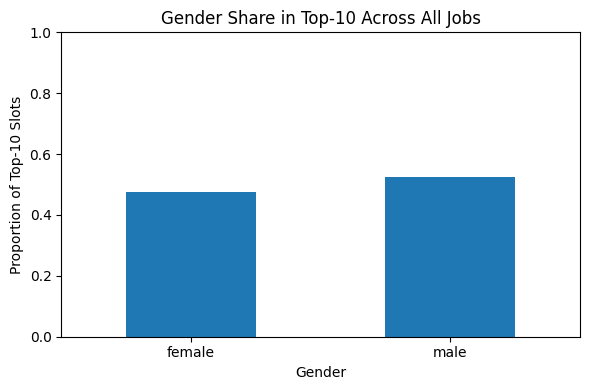

In [31]:
plt.figure(figsize=(6, 4))
top10_gender_ratios.plot(kind="bar")
plt.title("Gender Share in Top-10 Across All Jobs")
plt.ylabel("Proportion of Top-10 Slots")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

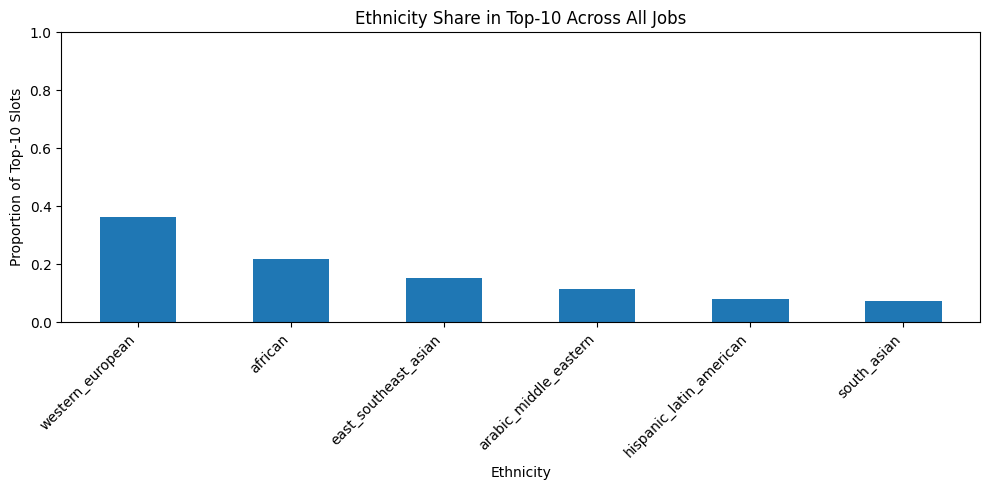

In [32]:
plt.figure(figsize=(10, 5))
top10_ethnicity_ratios.plot(kind="bar")
plt.title("Ethnicity Share in Top-10 Across All Jobs")
plt.ylabel("Proportion of Top-10 Slots")
plt.xlabel("Ethnicity")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---

# Analysis per job seniority level

In [33]:
path = os.path.join(OUT_DIR, 'top10_all_jobs_eu_ratio_jb_v2.csv')
top10_all_jobs = pd.read_csv(path)  

In [34]:
def get_top_k_by_level(df_top10, k):
    df_k = df_top10[df_top10["rank"] <= k].copy()

    gender_counts = df_k.groupby(["job_level", "gender"]).size().rename("count").reset_index()

    gender_props = (
        df_k.groupby("job_level")["gender"]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    eth_counts = df_k.groupby(["job_level", "ethnicity"]).size().rename("count").reset_index()

    eth_props = (
        df_k.groupby("job_level")["ethnicity"]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    return gender_counts, gender_props, eth_counts, eth_props

In [35]:
cutoffs = [3, 5, 7, 10]

results = {}

for k in cutoffs:
    g_counts, g_props, e_counts, e_props = get_top_k_by_level(top10_all_jobs, k)
    results[k] = {
        "gender_counts": g_counts,
        "gender_props": g_props,
        "eth_counts": e_counts,
        "eth_props": e_props
    }

In [36]:
from IPython.display import display, Markdown

md = ""

for k, d in results.items():
    md += f"## Top {k} Candidates\n\n"

    gender_df = d["gender_props"].copy()
    eth_df = d["eth_props"].copy()

    md += "### Gender Distribution\n"
    md += gender_df.pivot(index="job_level", columns="gender", values="proportion")\
                    .round(3).fillna(0).to_markdown() + "\n\n"

    md += "### Ethnicity Distribution\n"
    md += eth_df.pivot(index="job_level", columns="ethnicity", values="proportion")\
                .round(3).fillna(0).to_markdown() + "\n\n"

    md += "---\n\n"

display(Markdown(md))

## Top 3 Candidates

### Gender Distribution
| job_level   |   female |   male |
|:------------|---------:|-------:|
| Junior      |    0.62  |  0.38  |
| Lead        |    0.306 |  0.694 |
| Mid         |    0.481 |  0.519 |
| Senior      |    0.25  |  0.75  |

### Ethnicity Distribution
| job_level   |   african |   arabic_middle_eastern |   east_southeast_asian |   hispanic_latin_american |   south_asian |   western_european |
|:------------|----------:|------------------------:|-----------------------:|--------------------------:|--------------:|-------------------:|
| Junior      |     0.176 |                   0.028 |                  0.093 |                     0.093 |         0.037 |              0.574 |
| Lead        |     0.269 |                   0.046 |                  0.111 |                     0.009 |         0.028 |              0.537 |
| Mid         |     0.296 |                   0.065 |                  0.167 |                     0.056 |         0.065 |              0.352 |
| Senior      |     0.176 |                   0.12  |                  0.093 |                     0.028 |         0.056 |              0.528 |

---

## Top 5 Candidates

### Gender Distribution
| job_level   |   female |   male |
|:------------|---------:|-------:|
| Junior      |    0.617 |  0.383 |
| Lead        |    0.356 |  0.644 |
| Mid         |    0.483 |  0.517 |
| Senior      |    0.322 |  0.678 |

### Ethnicity Distribution
| job_level   |   african |   arabic_middle_eastern |   east_southeast_asian |   hispanic_latin_american |   south_asian |   western_european |
|:------------|----------:|------------------------:|-----------------------:|--------------------------:|--------------:|-------------------:|
| Junior      |     0.167 |                   0.028 |                  0.106 |                     0.139 |         0.056 |              0.506 |
| Lead        |     0.244 |                   0.089 |                  0.122 |                     0.017 |         0.044 |              0.483 |
| Mid         |     0.261 |                   0.083 |                  0.161 |                     0.072 |         0.05  |              0.372 |
| Senior      |     0.194 |                   0.128 |                  0.117 |                     0.039 |         0.067 |              0.456 |

---

## Top 7 Candidates

### Gender Distribution
| job_level   |   female |   male |
|:------------|---------:|-------:|
| Junior      |    0.619 |  0.381 |
| Lead        |    0.421 |  0.579 |
| Mid         |    0.496 |  0.504 |
| Senior      |    0.333 |  0.667 |

### Ethnicity Distribution
| job_level   |   african |   arabic_middle_eastern |   east_southeast_asian |   hispanic_latin_american |   south_asian |   western_european |
|:------------|----------:|------------------------:|-----------------------:|--------------------------:|--------------:|-------------------:|
| Junior      |     0.171 |                   0.063 |                  0.107 |                     0.135 |         0.067 |              0.456 |
| Lead        |     0.258 |                   0.115 |                  0.135 |                     0.032 |         0.048 |              0.413 |
| Mid         |     0.218 |                   0.103 |                  0.167 |                     0.079 |         0.063 |              0.369 |
| Senior      |     0.202 |                   0.143 |                  0.143 |                     0.044 |         0.075 |              0.393 |

---

## Top 10 Candidates

### Gender Distribution
| job_level   |   female |   male |
|:------------|---------:|-------:|
| Junior      |    0.6   |  0.4   |
| Lead        |    0.428 |  0.572 |
| Mid         |    0.517 |  0.483 |
| Senior      |    0.358 |  0.642 |

### Ethnicity Distribution
| job_level   |   african |   arabic_middle_eastern |   east_southeast_asian |   hispanic_latin_american |   south_asian |   western_european |
|:------------|----------:|------------------------:|-----------------------:|--------------------------:|--------------:|-------------------:|
| Junior      |     0.197 |                   0.078 |                  0.108 |                     0.15  |         0.069 |              0.397 |
| Lead        |     0.25  |                   0.133 |                  0.153 |                     0.036 |         0.067 |              0.361 |
| Mid         |     0.219 |                   0.114 |                  0.172 |                     0.094 |         0.069 |              0.331 |
| Senior      |     0.203 |                   0.133 |                  0.172 |                     0.047 |         0.086 |              0.358 |

---



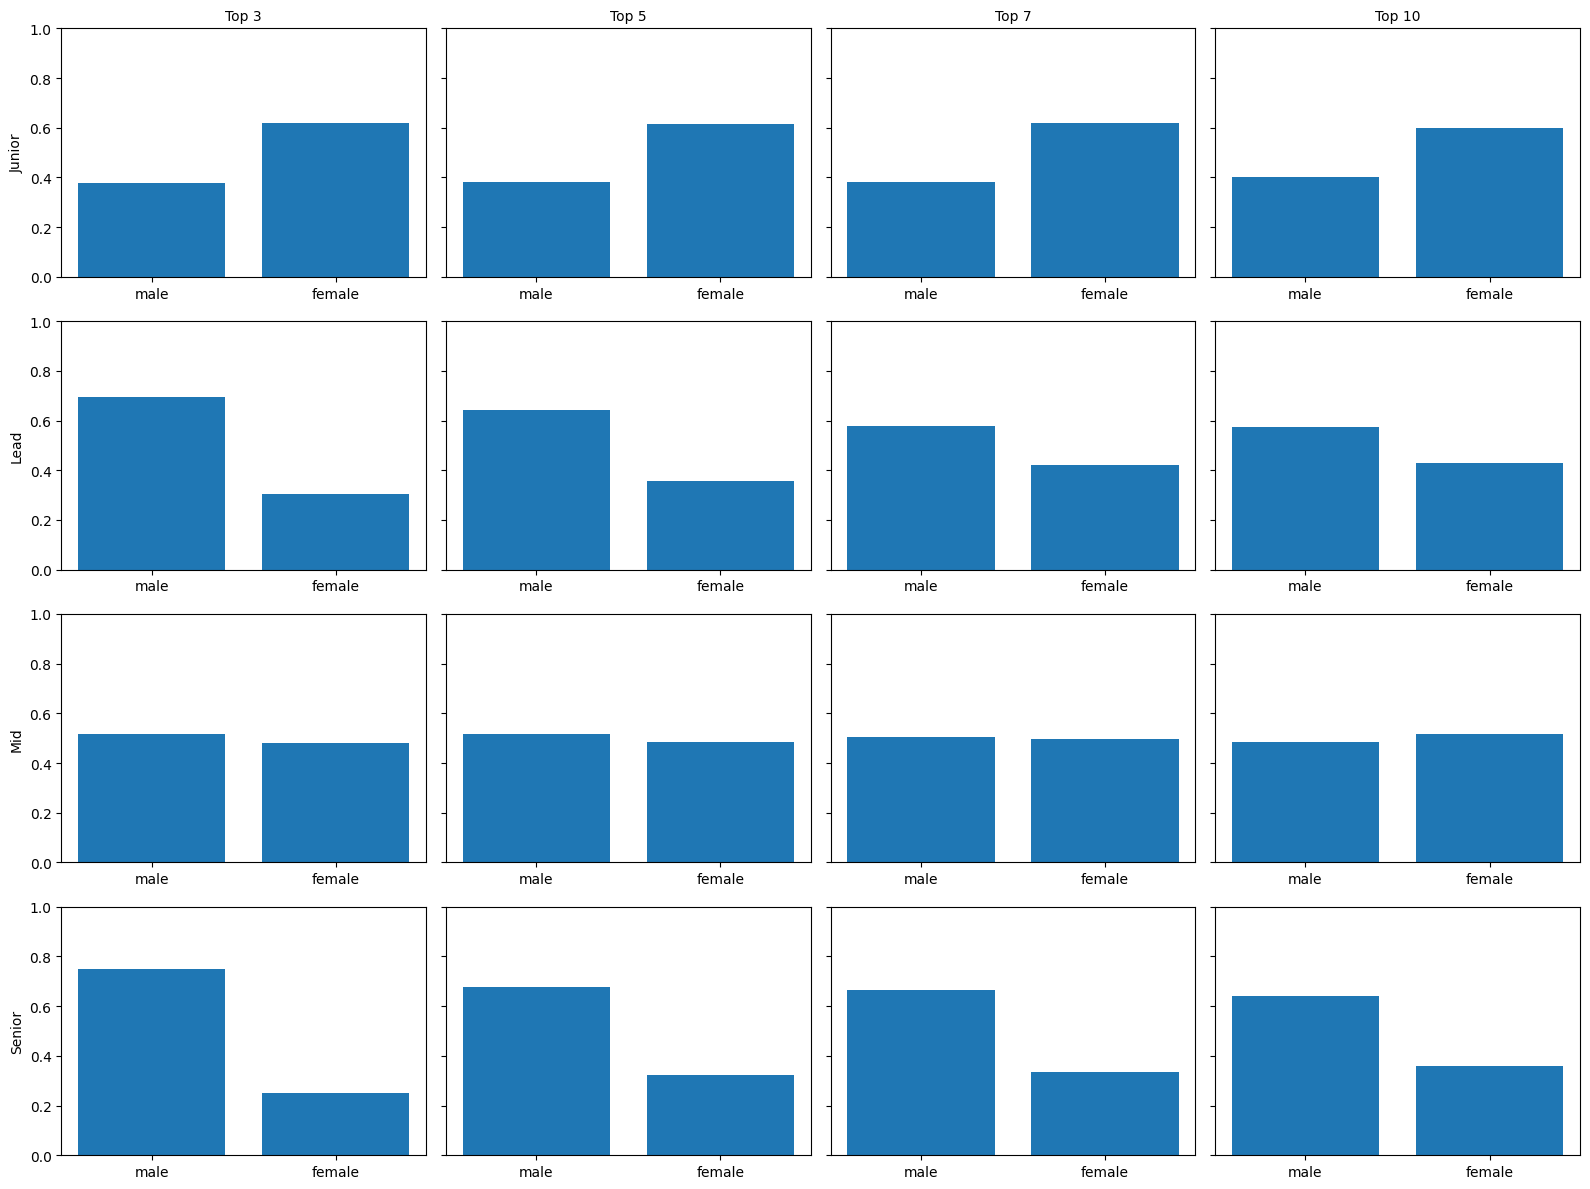

In [37]:
import warnings
warnings.filterwarnings("ignore")

# Rebuild combined df safely
rows = []
for k, d in results.items():
    df_k = d["gender_props"].copy()
    df_k["cutoff"] = k
    rows.append(df_k)

gender_props_all = pd.concat(rows, ignore_index=True)

# Normalize job_level to lowercase for grouping
gender_props_all["job_level"] = gender_props_all["job_level"].str.lower()

job_level_order = sorted(gender_props_all["job_level"].unique())
cutoff_order = sorted(gender_props_all["cutoff"].unique())

n_levels = len(job_level_order)
n_cutoffs = len(cutoff_order)

fig, axes = plt.subplots(
    nrows=n_levels,
    ncols=n_cutoffs,
    figsize=(4 * n_cutoffs, 3 * n_levels),
    sharey=True,
)

# If there is only one row or one column, axes won't be 2D; normalize that
if n_levels == 1 and n_cutoffs == 1:
    axes = [[axes]]
elif n_levels == 1:
    axes = [axes]
elif n_cutoffs == 1:
    axes = [[ax] for ax in axes]

gender_order = ["male", "female"]  # or whatever order you want

for i, level in enumerate(job_level_order):
    for j, k in enumerate(cutoff_order):
        ax = axes[i][j]

        df_plot = gender_props_all[
            (gender_props_all["job_level"] == level)
            & (gender_props_all["cutoff"] == k)
        ]

        # If no data for this combo, turn axis off
        if df_plot.empty:
            ax.set_axis_off()
            continue

        # Enforce consistent order of bars
        df_plot = df_plot.set_index("gender")

        # Keep only genders that actually appear in this subset
        valid_order = [g for g in gender_order if g in df_plot.index]

        df_plot = df_plot.loc[valid_order].reset_index()

        ax.bar(df_plot["gender"], df_plot["proportion"])
        ax.set_ylim(0, 1)

        if i == 0:
            ax.set_title(f"Top {k}", fontsize=10)

        if j == 0:
            ax.set_ylabel(level.capitalize())

        ax.set_xticklabels(df_plot["gender"])

plt.tight_layout()
plt.show()

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_eth_for_k(results, k=3, eth_order=None):
    rows = []
    for _k, d in results.items():
        df_k = d["eth_props"].copy()
        df_k["cutoff"] = _k
        rows.append(df_k)
    
    eth_props_all = pd.concat(rows, ignore_index=True)
    
    # Normalize types
    # Convert cutoff to int if possible
    eth_props_all["cutoff"] = eth_props_all["cutoff"].astype(int)
    cutoff_for_eth = int(k)

    # Normalize job_level to lowercase
    eth_props_all["job_level"] = eth_props_all["job_level"].str.lower()
    job_level_order = sorted(eth_props_all["job_level"].unique())

    # Optional: quick sanity check
    print("Available cutoffs in eth_props_all:", sorted(eth_props_all["cutoff"].unique()))
    print("Requested cutoff:", cutoff_for_eth)

    fig, axes = plt.subplots(
        nrows=len(job_level_order),
        ncols=1,
        figsize=(10, 4 * len(job_level_order)),
    )
    
    if len(job_level_order) == 1:
        axes = [axes]

    for i, level in enumerate(job_level_order):
        ax = axes[i]
    
        df_plot = eth_props_all[
            (eth_props_all["job_level"] == level)
            & (eth_props_all["cutoff"] == cutoff_for_eth)
        ]
    
        if df_plot.empty:
            ax.set_axis_off()
            continue

        # Optional: enforce consistent ethnicity order
        if eth_order is not None:
            df_plot = df_plot.set_index("ethnicity")
            valid_order = [e for e in eth_order if e in df_plot.index]
            df_plot = df_plot.loc[valid_order].reset_index()

        ax.bar(df_plot["ethnicity"], df_plot["proportion"])
        ax.set_ylim(0, 1)
        ax.set_ylabel(level.capitalize())
        ax.set_xticklabels(df_plot["ethnicity"], rotation=45, ha="right")
    
        if i == 0:
            ax.set_title(f"Ethnicity distribution – Top {cutoff_for_eth}", fontsize=12)
    
    plt.tight_layout()
    plt.show()

Available cutoffs in eth_props_all: [3, 5, 7, 10]
Requested cutoff: 3


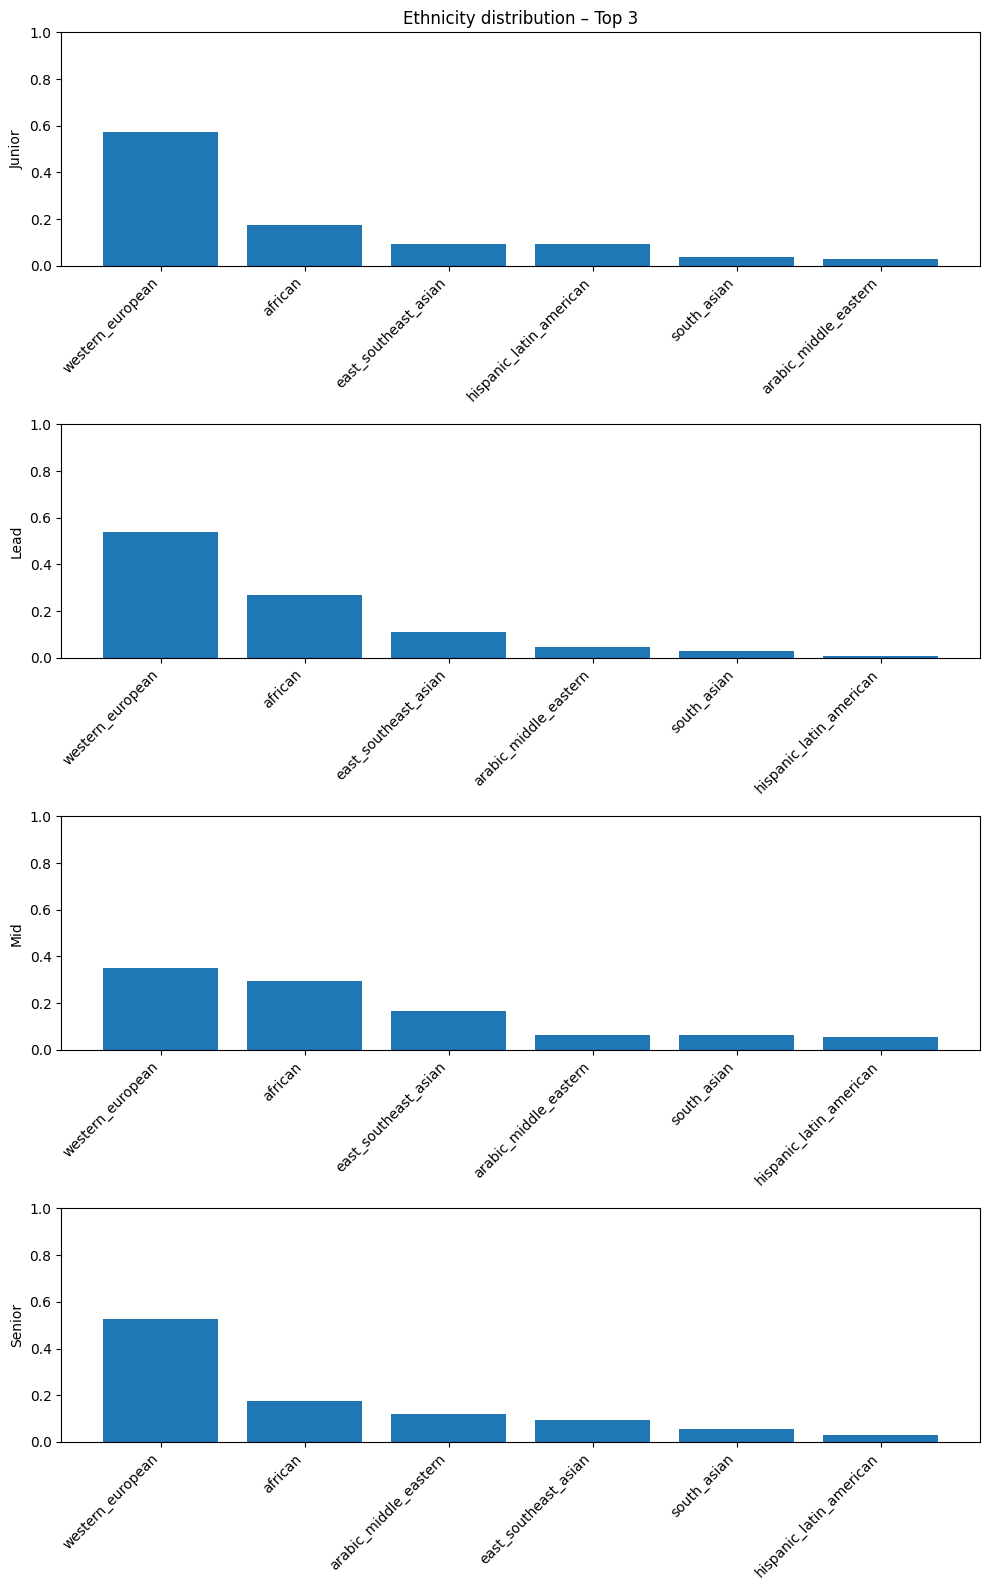

In [39]:
visualize_eth_for_k(results, k=3)

Available cutoffs in eth_props_all: [3, 5, 7, 10]
Requested cutoff: 5


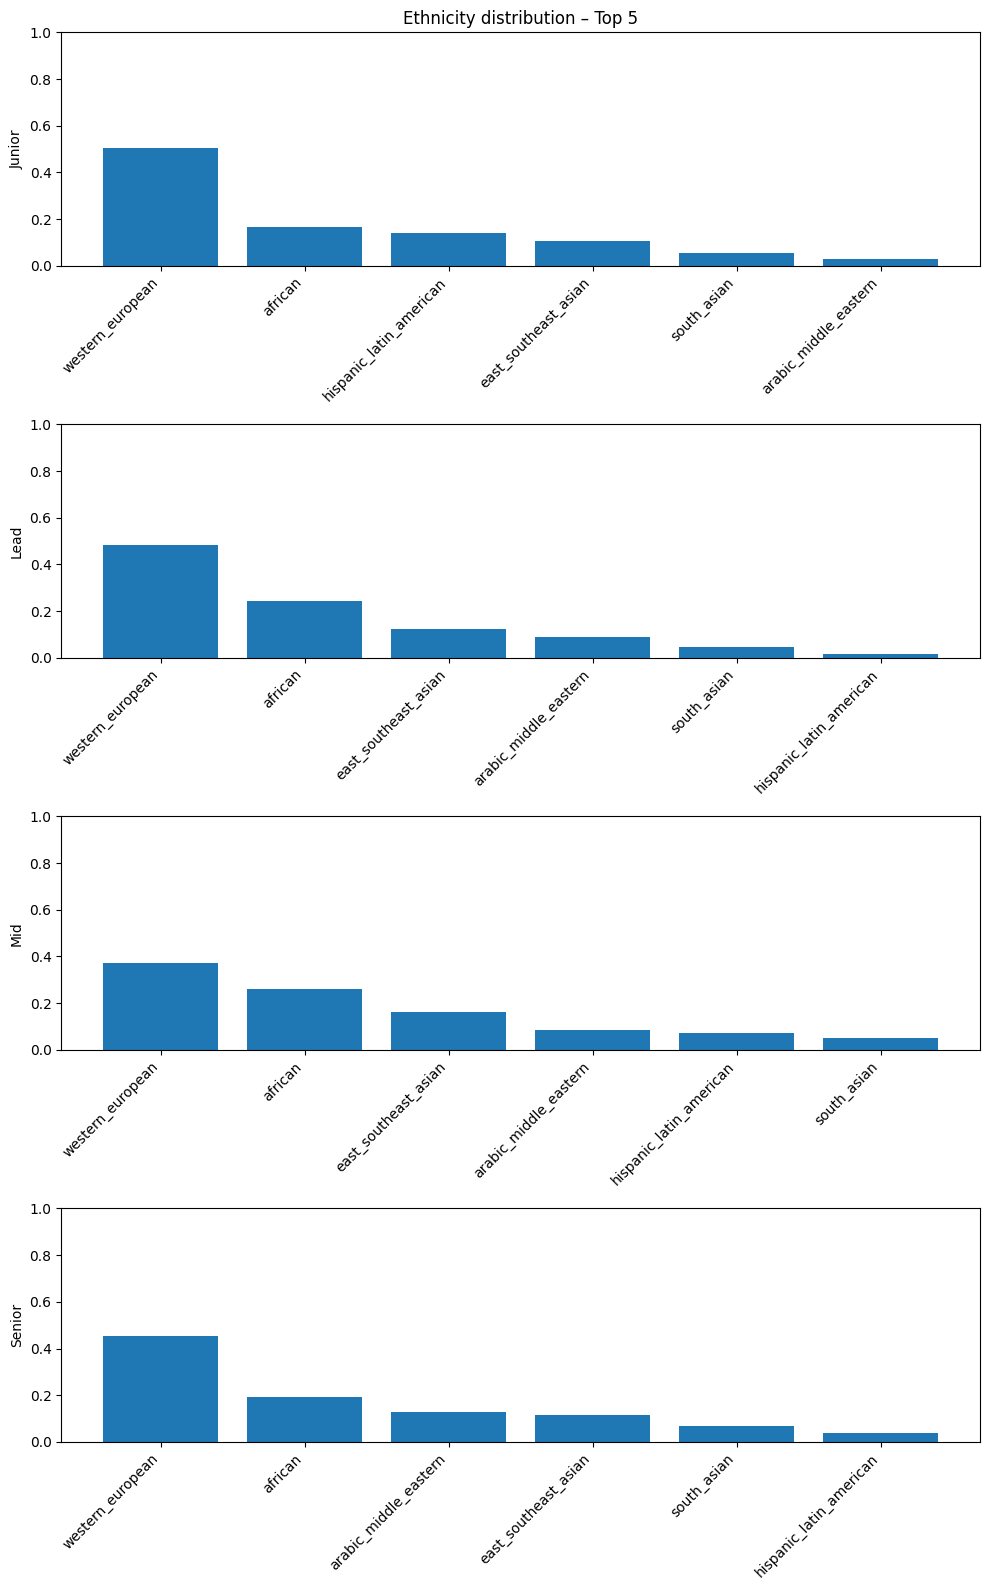

In [40]:
visualize_eth_for_k(results, k=5)

Available cutoffs in eth_props_all: [3, 5, 7, 10]
Requested cutoff: 7


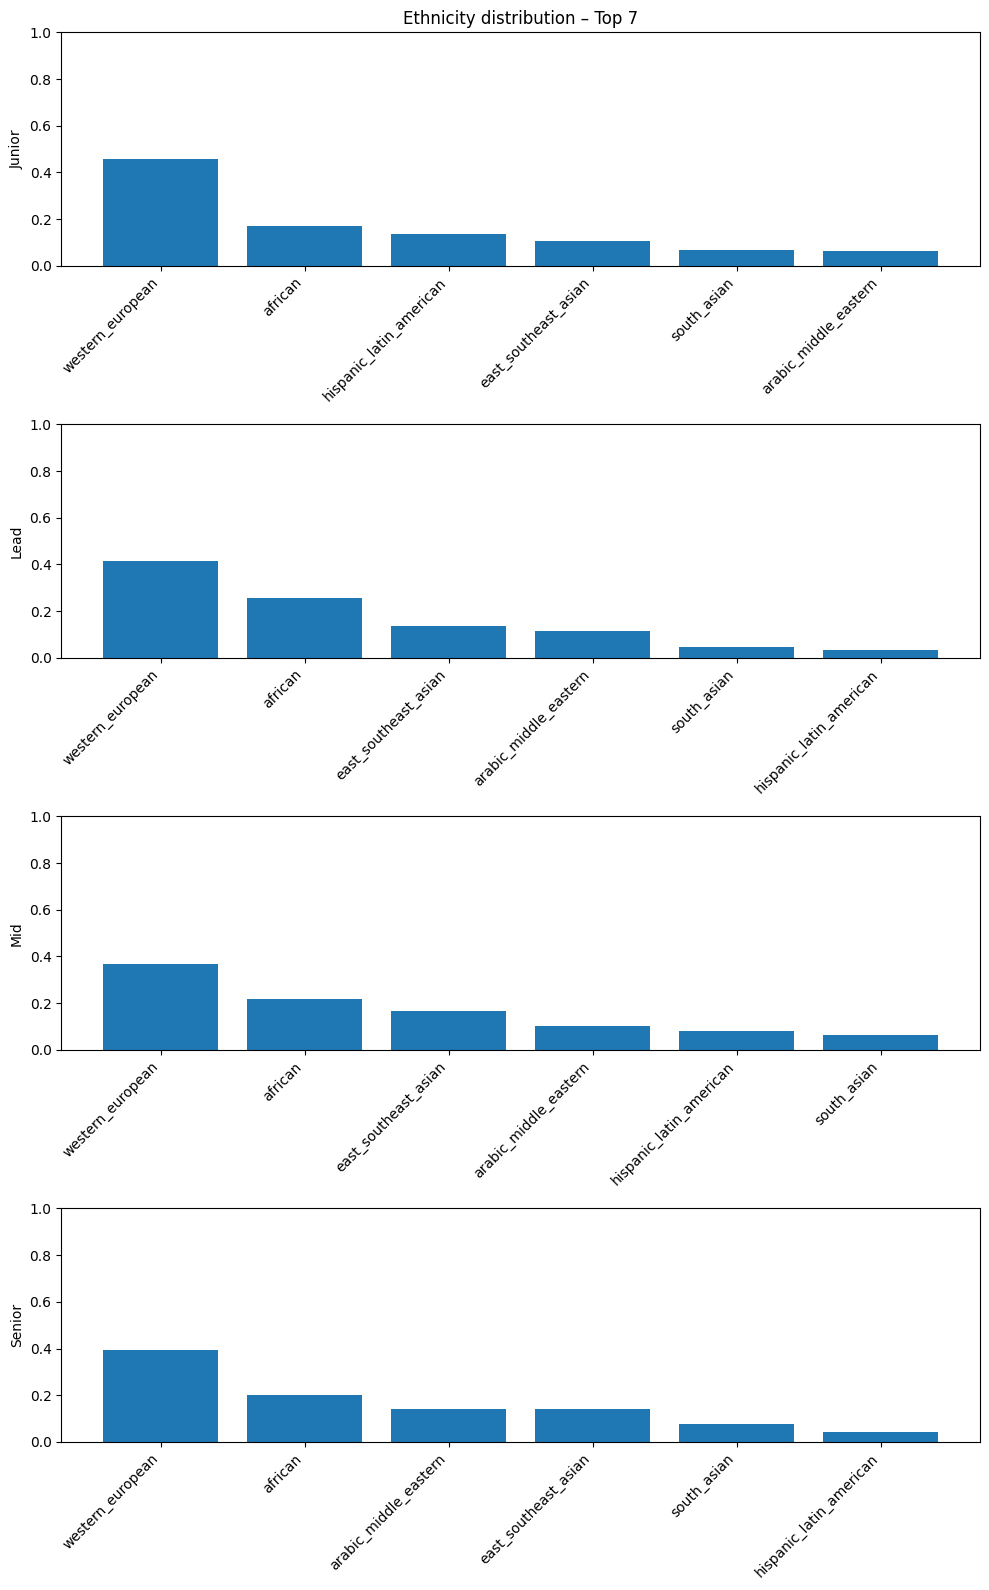

In [41]:
visualize_eth_for_k(results, k=7)

Available cutoffs in eth_props_all: [3, 5, 7, 10]
Requested cutoff: 10


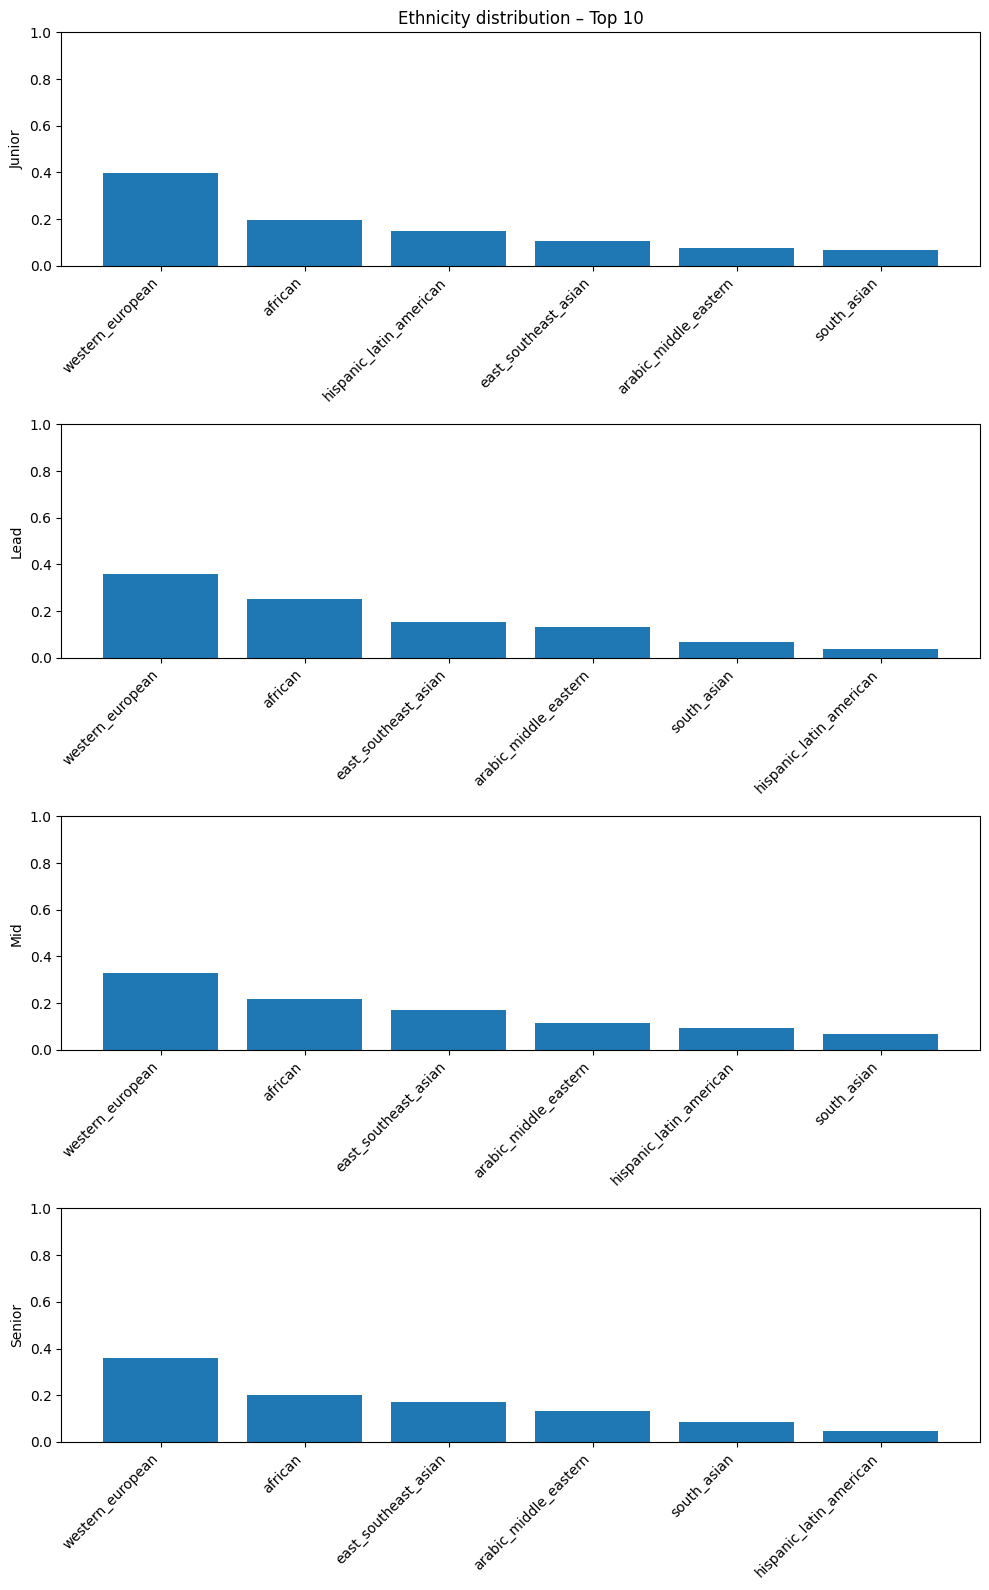

In [42]:
visualize_eth_for_k(results, k=10)